In [22]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('D:/work/Rheumatoid arthritis/data/train.csv')
ar = np.array(train)
rownames = ar[:,0]
colnames = train.columns[1:]
ar = ar[:,1:]
train = pd.DataFrame(ar)
train.index = rownames
train.columns = colnames
train = np.transpose(train)

In [3]:
test = pd.read_csv('D:/work/Rheumatoid arthritis/data/test.csv')
ar = np.array(test)
rownames = ar[:,0]
colnames = test.columns[1:]
ar = ar[:,1:]
test = pd.DataFrame(ar)
test.index = rownames
test.columns = colnames
test = np.transpose(test)

In [4]:
class BPNN(nn.Module):
    def __init__(self, num_features):
        super(BPNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(in_features = num_features, out_features = num_features), nn.BatchNorm1d(num_features), nn.Sigmoid())
        self.fc2 = nn.Sequential(nn.Linear(in_features = num_features, out_features = 1), nn.Sigmoid())
    def forward(self, train_x):
        forward_fc1 = self.fc1(train_x)
        forward_y = self.fc2(forward_fc1)
        return forward_y
    
def BPNN_train(train_x, train_y, num_iterations, lr):
    model = BPNN(train_x.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    lossfunction = nn.BCELoss()
    
    l = []
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        forward_y = model.forward(train_x)
        loss = lossfunction(forward_y, train_y)
        l.append(loss)
        
        loss.backward()
        optimizer.step()
    return model, l

In [5]:
x = np.array(train)
rownames = list(train.index)
y = []
for row in rownames:
    if row[:2] == 'RA':
        y.append(1)
    if row[:2] == 'HC':
        y.append(0)
y = np.array(y)

test_x = np.array(test)
test_x = test_x.astype(np.float32)
rownames = list(test.index)
test_y = []
for row in rownames:
    if row[:2] == 'RA':
        test_y.append(1)
    if row[:2] == 'HC':
        test_y.append(0)
test_y = np.array(test_y)

num_validations = 100
num_cutoff = 100
penalty = 'l1'
C = 1
validation_size = 100
lr = 0.001
num_iterations = 1000
train_tpr_matrix = np.zeros((num_validations, num_cutoff))
train_fpr_matrix = np.zeros((num_validations, num_cutoff))
train_sens_matrix = np.zeros((num_validations, num_cutoff))
train_spec_matrix = np.zeros((num_validations, num_cutoff))
train_ppv_matrix = np.zeros((num_validations, num_cutoff))
train_npv_matrix = np.zeros((num_validations, num_cutoff))
test_tpr_matrix = np.zeros((num_validations, num_cutoff))
test_fpr_matrix = np.zeros((num_validations, num_cutoff))
test_sens_matrix = np.zeros((num_validations, num_cutoff))
test_spec_matrix = np.zeros((num_validations, num_cutoff))
test_ppv_matrix = np.zeros((num_validations, num_cutoff))
test_npv_matrix = np.zeros((num_validations, num_cutoff))

for i in range(num_validations):
    train_x, validation_x, train_y, validation_y = train_test_split(x, y, test_size = validation_size)

    train_x = train_x.astype(np.float32)
    train_x = Variable(torch.tensor(train_x, dtype=torch.float32))
    train_y = Variable(torch.tensor(train_y, dtype=torch.float32))
    train_y = train_y.unsqueeze(1)
    test_x = Variable(torch.tensor(test_x, dtype=torch.float32))
    test_y = Variable(torch.tensor(test_y, dtype=torch.float32))
    model, losses = BPNN_train(train_x, train_y, num_iterations = num_iterations, lr = lr)
    
    train_probability = list(model.forward(train_x).data.numpy()[:,0])
    test_probability = list(model.forward(test_x).data.numpy()[:,0])
    
    for j in range(num_cutoff):
        cutoff = j / 100
        tp, fp, tn, fn = 0, 0, 0, 0
        for k in range(len(train_probability)):
            if train_probability[k] >= cutoff and train_y[k] == 1:
                tp += 1
            elif train_probability[k] >= cutoff and train_y[k] == 0:
                fp += 1
            elif train_probability[k] < cutoff and train_y[k] == 0:
                tn += 1
            elif train_probability[k] < cutoff and train_y[k] == 1:
                fn += 1
        train_tpr_matrix[i,j] = tp / (tp + fn + 0.00001)
        train_fpr_matrix[i,j] = fp / (fp + tn + 0.00001)
        train_sens_matrix[i,j] = tp / (tp + fn + 0.00001)
        train_spec_matrix[i,j] = tn / (tn + fp + 0.00001)
        train_ppv_matrix[i,j] = tp / (tp + fp + 0.00001)
        train_npv_matrix[i,j] = tn / (tn + fn + 0.00001)
    
    for j in range(num_cutoff):
        cutoff = j / 100
        tp, fp, tn, fn = 0, 0, 0, 0
        for k in range(len(test_probability)):
            if test_probability[k] >= cutoff and test_y[k] == 1:
                tp += 1
            elif test_probability[k] >= cutoff and test_y[k] == 0:
                fp += 1
            elif test_probability[k] < cutoff and test_y[k] == 0:
                tn += 1
            elif test_probability[k] < cutoff and test_y[k] == 1:
                fn += 1
        test_tpr_matrix[i,j] = tp / (tp + fn + 0.00001)
        test_fpr_matrix[i,j] = fp / (fp + tn + 0.00001)
        test_sens_matrix[i,j] = tp / (tp + fn + 0.00001)
        test_spec_matrix[i,j] = tn / (tn + fp + 0.00001)
        test_ppv_matrix[i,j] = tp / (tp + fp + 0.00001)
        test_npv_matrix[i,j] = tn / (tn + fn + 0.00001)
        
test_tpr_mean, test_tpr_up_mean, test_tpr_down_mean, test_fpr_mean, test_fpr_up_mean, test_fpr_down_mean, test_sens_mean, test_spec_mean, test_ppv_mean, test_npv_mean, test_auc_l, test_cutoff = [], [], [], [], [], [], [], [], [], [], [], []
train_tpr_mean, train_tpr_up_mean, train_tpr_down_mean, train_fpr_mean, train_fpr_up_mean, train_fpr_down_mean, train_sens_mean, train_spec_mean, train_ppv_mean, train_npv_mean, train_auc_l, train_cutoff = [], [], [], [], [], [], [], [], [], [], [], []
for i in range(num_validations):
    train_auc_l.append(auc(train_fpr_matrix[i,:], train_tpr_matrix[i,:]))
for i in range(num_validations):
    test_auc_l.append(auc(test_fpr_matrix[i,:], test_tpr_matrix[i,:]))
for j in range(num_cutoff):
    train_cutoff.append(j / num_cutoff)
    train_tpr_mean.append(np.mean(train_tpr_matrix[:,j]))
    train_tpr_up_mean.append(np.mean(train_tpr_matrix[:,j]) + (np.std(train_tpr_matrix[:,j]) / num_validations) * 1.96)
    train_tpr_down_mean.append(np.mean(train_tpr_matrix[:,j]) - (np.std(train_tpr_matrix[:,j]) / num_validations) * 1.96)
    train_fpr_mean.append(np.mean(train_fpr_matrix[:,j]))
    train_fpr_up_mean.append(np.mean(train_fpr_matrix[:,j]) + (np.std(train_fpr_matrix[:,j]) / num_validations) * 1.96)
    train_fpr_down_mean.append(np.mean(train_fpr_matrix[:,j]) - (np.std(train_fpr_matrix[:,j]) / num_validations) * 1.96)
    train_sens_mean.append(np.mean(train_sens_matrix[:,j]))
    train_spec_mean.append(np.mean(train_spec_matrix[:,j]))
    train_ppv_mean.append(np.mean(train_ppv_matrix[:,j]))
    train_npv_mean.append(np.mean(train_npv_matrix[:,j]))
    
    test_cutoff.append(j / num_cutoff)
    test_tpr_mean.append(np.mean(test_tpr_matrix[:,j]))
    test_tpr_up_mean.append(np.mean(test_tpr_matrix[:,j]) + (np.std(test_tpr_matrix[:,j]) / num_validations) * 1.96)
    test_tpr_down_mean.append(np.mean(test_tpr_matrix[:,j]) - (np.std(test_tpr_matrix[:,j]) / num_validations) * 1.96)
    test_fpr_mean.append(np.mean(test_fpr_matrix[:,j]))
    test_fpr_up_mean.append(np.mean(test_fpr_matrix[:,j]) + (np.std(test_fpr_matrix[:,j]) / num_validations) * 1.96)
    test_fpr_down_mean.append(np.mean(test_fpr_matrix[:,j]) - (np.std(test_fpr_matrix[:,j]) / num_validations) * 1.96)
    test_sens_mean.append(np.mean(test_sens_matrix[:,j]))
    test_spec_mean.append(np.mean(test_spec_matrix[:,j]))
    test_ppv_mean.append(np.mean(test_ppv_matrix[:,j]))
    test_npv_mean.append(np.mean(test_npv_matrix[:,j]))

C:\Users\win 10\anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\win 10\anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [26]:
train_x = x.astype(np.float32)
train_x = Variable(torch.tensor(train_x, dtype=torch.float32))
train_y = Variable(torch.tensor(y, dtype=torch.float32))
train_y = train_y.unsqueeze(1)
test_x = Variable(torch.tensor(test_x, dtype=torch.float32))
test_y = Variable(torch.tensor(test_y, dtype=torch.float32))

train_probability = list(model.forward(train_x).data.numpy()[:,0])
cutoff = 0.6
tp, fp, tn, fn = 0, 0, 0, 0
for k in range(len(train_probability)):
    if train_probability[k] >= cutoff and train_y[k] == 1:
        tp += 1
    elif train_probability[k] >= cutoff and train_y[k] == 0:
        fp += 1
    elif train_probability[k] < cutoff and train_y[k] == 0:
        tn += 1
    elif train_probability[k] < cutoff and train_y[k] == 1:
        fn += 1
accuracy = (tp + tn) / (tp + fp + tn + fn)
print(accuracy)

0.9620081411126187


C:\Users\win 10\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
C:\Users\win 10\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [27]:
index=60
print(np.mean(train_sens_matrix[:, index]), (np.std(train_sens_matrix[:, index]) / 100) * 1.96)
print(np.mean(train_spec_matrix[:, index]), (np.std(train_spec_matrix[:, index]) / 100) * 1.96)
print(np.mean(train_ppv_matrix[:, index]), (np.std(train_ppv_matrix[:, index]) / 100) * 1.96)
print(np.mean(train_npv_matrix[:, index]), (np.std(train_npv_matrix[:, index]) / 100) * 1.96)

0.9340632299020842 0.0001199620994662397
0.9979614920655999 4.565772651252493e-05
0.9983503994920454 3.6695275625835876e-05
0.9200738307426246 0.00014020440505294168


In [28]:
print(auc(train_fpr_mean, train_tpr_mean), (np.std(train_auc_l) / 100) * 1.96)

0.9972612806097444 8.952307361709086e-06


In [29]:
stats.ttest_1samp(train_auc_l, 0.99).pvalue

1.4884195522512136e-120

In [41]:
result = np.transpose(pd.DataFrame([train_tpr_up_mean, train_tpr_mean, train_tpr_down_mean, train_fpr_up_mean, train_fpr_mean, train_fpr_down_mean, train_sens_mean, train_spec_mean, train_ppv_mean, train_npv_mean], index = ['TPR_up', 'TPR', 'TPR_down', 'FPR_up', 'FPR', 'FPR_down', 'Sens', 'Spec', 'PPV', 'NPV'], columns=train_cutoff))
result.to_csv('D:/work/Rheumatoid arthritis/result/modeling/BPNN_train.csv')

lasso_auc = pd.DataFrame(train_auc_l, columns = ['BPNN'])
lasso_auc.to_csv('D:/work/Rheumatoid arthritis/result/modeling/BPNN_AUC_train.csv')

In [42]:
result = np.transpose(pd.DataFrame([test_tpr_up_mean, test_tpr_mean, test_tpr_down_mean, test_fpr_up_mean, test_fpr_mean, test_fpr_down_mean, test_sens_mean, test_spec_mean, test_ppv_mean, test_npv_mean], index = ['TPR_up', 'TPR', 'TPR_down', 'FPR_up', 'FPR', 'FPR_down', 'Sens', 'Spec', 'PPV', 'NPV'], columns=test_cutoff))
result.to_csv('D:/work/Rheumatoid arthritis/result/modeling/BPNN_test.csv')

lasso_auc = pd.DataFrame(test_auc_l, columns = ['BPNN'])
lasso_auc.to_csv('D:/work/Rheumatoid arthritis/result/modeling/BPNN_AUC_test.csv')

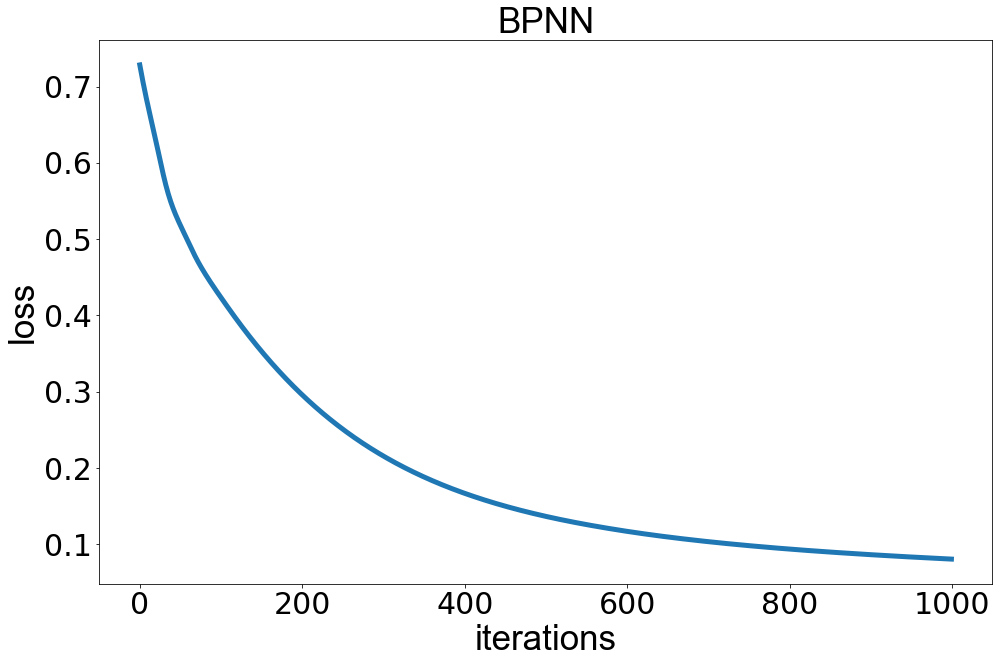

In [46]:
plt.figure(figsize=(16,10))
formation={'family':'Arial','size':35}
plt.xlabel('iterations',formation)
plt.ylabel('loss',formation)
plt.title('BPNN',formation)
plt.tick_params(labelsize=30)
plt.plot(losses, linewidth=5)
plt.savefig('D:/work/Rheumatoid arthritis/result/modeling/BPNN_loss.png')